<a href="https://colab.research.google.com/github/CH0900/114-1Business-Intelligence/blob/main/0910_week1_5113029043.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 股市資料蒐集、爬蟲



## 取得證交所資料
1. 進入證交所網址：https://www.twse.com.tw/zh/index.html
2. 使用開發者模式取得請求資料網址

### 匯入套件

In [12]:
# 發送 HTTP 請求以獲取網路上的資料
import requests

# 用來處理和分析結構化數據
import pandas as pd

# 用來處理時間
import datetime as dt

### 取得證交所上市公司個股日成交資訊

In [13]:
# "華邦電"股票代號
stock_id = '2344'

# 獲取今天的日期（型別：str）
date = dt.date.today().strftime("%Y%m%d")
# date = 20241101

print('今日日期：', date)

# 取得證交所網站資料，帶入網址參數 date：時間，stock_id：股票代號
# https://www.twse.com.tw/rwd/zh/afterTrading/STOCK_DAY?date=20240918&stockNo=2303
stock_data = requests.get(f'https://www.twse.com.tw/rwd/zh/ \
            afterTrading/STOCK_DAY?date={date}&stockNo={stock_id}')

# 將結果轉換 JSON 格式
json_data = stock_data.json()

# 將 JSON 格式轉換爲 Dataframe 格式，
# 方便在 Python 中處理結構化資料
df = pd.DataFrame(data=json_data['data'],
                  columns=json_data['fields'])

df

今日日期： 20250915


,日期,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數
0,114/09/01,"79,269,429","1,590,942,508",19.70,20.35,19.60,20.30,+0.60,"23,880"
1,114/09/02,"100,967,634","2,035,398,991",20.50,20.65,19.80,19.95,-0.35,"28,982"
2,114/09/03,"65,368,703","1,322,465,466",19.95,20.55,19.90,20.10,+0.15,"18,065"
3,114/09/04,"65,653,280","1,347,946,204",20.40,20.80,20.30,20.50,+0.40,"18,539"
4,114/09/05,"227,254,069","4,992,131,427",20.65,22.55,20.60,22.55,+2.05,"60,412"
5,114/09/08,"436,611,844","10,572,092,448",24.65,24.80,22.75,24.60,+2.05,"109,218"
6,114/09/09,"237,839,246","5,764,269,263",24.40,24.90,23.70,24.55,-0.05,"71,135"
7,114/09/10,"285,159,030","7,189,180,523",24.85,25.70,24.50,24.95,+0.40,"83,227"
8,114/09/11,"311,904,444","7,978,439,289",25.70,26.60,24.70,25.00,+0.05,"99,894"
9,114/09/12,"275,412,454","7,125,219,924",26.15,26.55,24.90,25.45,+0.45,"81,588"


### 抓取特定某段時間區間 9/10~9/15
為了比較時間區間，必須要把「日期」欄位轉圜為 Pandas 中的 datetime 格式

In [14]:
def convert_minguo_to_ad(date_str):
    # 113/09/10 透過「/」分割成清單 [113, 09, 10]
    # 分配給變數 year=113, month=09, day=10
    year, month, day = date_str.split('/')
    ad_year = int(year) + 1911  # 將民國年轉換為西元年
    return f"{ad_year}/{month}/{day}"

# 所有民國日期都轉西元日期 e.g.113/09/10 -> 2024/09/10
df['日期'] = df['日期'].apply(convert_minguo_to_ad)

# 轉換為 pandas 中的 datetime 格式
df['日期'] = pd.to_datetime(df['日期'], format='%Y/%m/%d')

start_date = '2025/09/07'
end_date = '2025/09/15'

# 篩選日期
filtered_df = df[(df['日期'] >= start_date) & (df['日期'] <= end_date)]

print(filtered_df)

           日期         成交股數            成交金額    開盤價    最高價    最低價    收盤價   漲跌價差  \
5  2025-09-08  436,611,844  10,572,092,448  24.65  24.80  22.75  24.60  +2.05   
6  2025-09-09  237,839,246   5,764,269,263  24.40  24.90  23.70  24.55  -0.05   
7  2025-09-10  285,159,030   7,189,180,523  24.85  25.70  24.50  24.95  +0.40   
8  2025-09-11  311,904,444   7,978,439,289  25.70  26.60  24.70  25.00  +0.05   
9  2025-09-12  275,412,454   7,125,219,924  26.15  26.55  24.90  25.45  +0.45   
10 2025-09-15  468,174,930  12,476,488,075  26.95  27.10  25.70  26.80  +1.35   

       成交筆數  
5   109,218  
6    71,135  
7    83,227  
8    99,894  
9    81,588  
10  132,731  


### 取得連續月份資料
以個股本益比為例

In [15]:
# 設定查找時間
date_list = ['20250401','20250501','20250601','20250701', '20250801', '20250901']

all_df = pd.DataFrame()

# 使用迴圈抓取連續月份資料
for date in date_list:
    # 取得證交所網站資料，帶入網址參數 date：時間，stock_id：股票代號
    # https://www.twse.com.tw/rwd/zh/afterTrading/STOCK_DAY?date=20240918&stockNo=2303
    # https://www.twse.com.tw/rwd/zh/afterTrading/BWIBBU?date=20240303&stockNo=2303
    url = f'https://www.twse.com.tw/rwd/zh/afterTrading/\
      BWIBBU?date={date}&stockNo={stock_id}'

    try:

        # 取得證交所網站資
        stock_data = requests.get(url)

        # 將結果轉換 JSON 格式
        json_data = stock_data.json()

        # 將 JSON 格式轉換爲 Dataframe 格式，
        # 方便在 Python 中處理結構化資料
        df = pd.DataFrame(data=json_data['data'],
                          columns=json_data['fields'])

        # 添加新數據
        all_df = pd.concat([all_df, df], ignore_index=True)

    except Exception as e:

        # 發生錯誤時，列印錯誤訊息
        print(f'無法取得{date}的資料, 可能資料量不足.')


# 輸出前 5 筆資料
#print(all_df)
all_df

,日期,殖利率(%),股利年度,本益比,股價淨值比,財報年/季
0,114年04月01日,0.00,112,139.23,0.89,113/4
1,114年04月02日,0.00,112,143.85,0.92,113/4
2,114年04月07日,0.00,112,129.62,0.83,113/4
3,114年04月08日,0.00,112,116.92,0.75,113/4
4,114年04月09日,0.00,112,105.38,0.67,113/4
...,...,...,...,...,...,...
111,114年09月09日,0.00,113,-,1.26,114/2
112,114年09月10日,0.00,113,-,1.28,114/2
113,114年09月11日,0.00,113,-,1.28,114/2
114,114年09月12日,0.00,113,-,1.31,114/2


## 使用 Yahoo Finance 取得資料

###匯入套件

In [16]:
!pip install yfinance

In [17]:
# yahoo finance 套件
import yfinance as yf
# 用來處理和分析結構化數據
import pandas as pd

# 用來處理時間
import datetime as dt

In [18]:
# 輸入股票代號
# "華邦電"股票代號
stock_id = "2344.tw"
# stock_id = "2357.tw"
# stock_id = "AAPL"
# stock_id = "NVDA"

'''今天往前算幾天'''
# 資料結束時間
end = dt.date.today()
# 抓取半年資料（現在-過去180天）
#start = end - dt.timedelta(days=180)

'''抓取特定時間'''
start = dt.datetime(2025, 1, 1)  # 指定的開始日期
# end = dt.datetime(2024, 6, 30)    # 指定的結束日期


# 參數1: 股票代號, 參數2: 開始時間, 參數3: 結束時間
df = yf.download(stock_id, start=start, end=end).reset_index()

# 刪除 Ticker 欄位並取代
df.columns = df.columns.droplevel('Ticker')

df

/tmp/ipython-input-1216018541.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock_id, start=start, end=end).reset_index()
[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
0,2025-01-02,14.500000,14.800000,14.500000,14.600000,13248335
1,2025-01-03,14.400000,14.850000,14.400000,14.600000,13828299
2,2025-01-06,14.800000,14.900000,14.400000,14.600000,17140993
3,2025-01-07,14.650000,15.550000,14.650000,15.100000,29905323
4,2025-01-08,14.500000,14.750000,14.450000,14.750000,12999680
...,...,...,...,...,...,...
164,2025-09-08,24.600000,24.799999,22.750000,24.650000,435706691
165,2025-09-09,24.549999,24.900000,23.700001,24.400000,237398509
166,2025-09-10,24.950001,25.700001,24.500000,24.850000,284634798
167,2025-09-11,25.000000,26.600000,24.700001,25.700001,311276352


# <b>資料可視化</b>

## 可視化收盤價折線圖

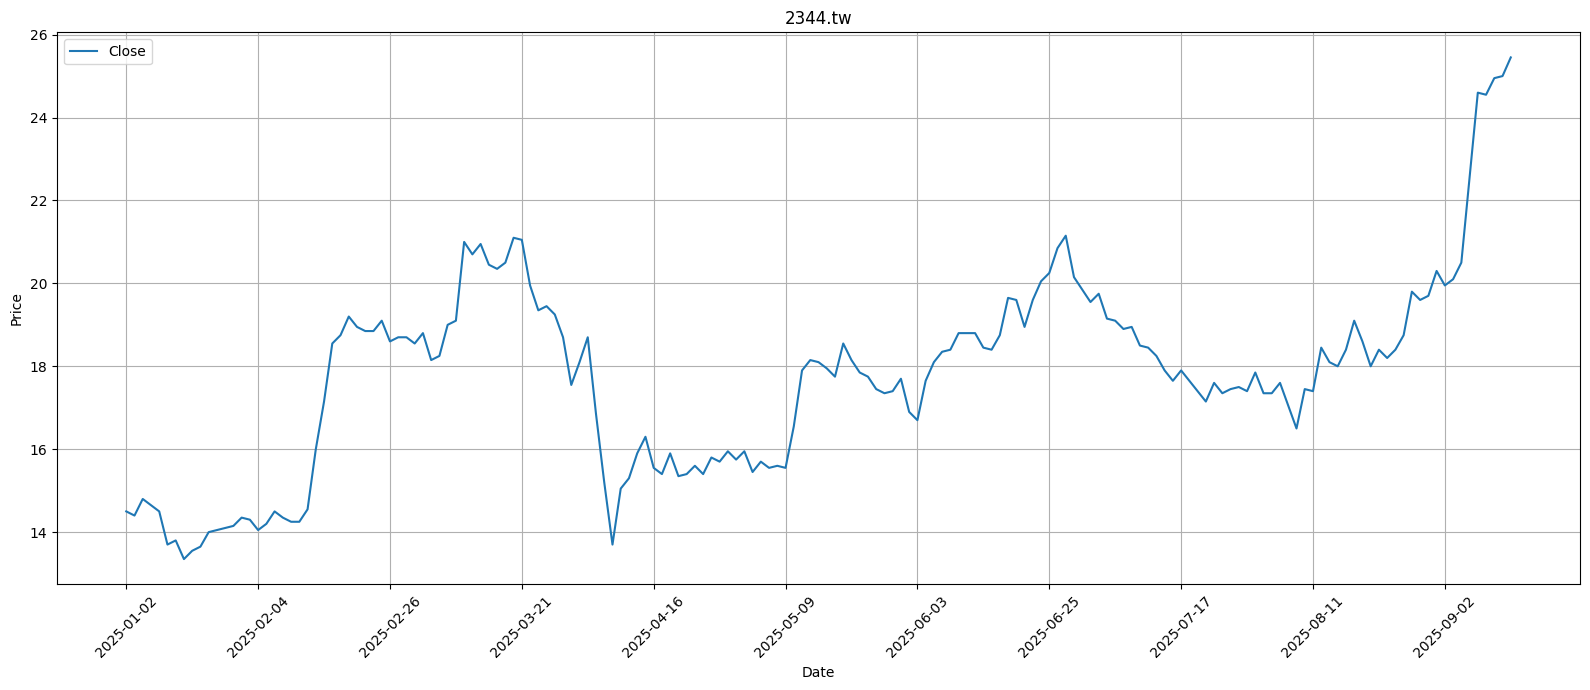

In [19]:
import matplotlib.pyplot as plt

# 畫布尺寸大小設定
plt.figure(figsize=(16, 7))

# 設定要繪製的資料欄位
plt.plot(df['Close'], label='Close')

# 設定 x 軸的時間
num = 10
date = df["Date"].dt.strftime('%Y-%m-%d')
plt.xticks(date[::len(date)//num].index,  # 設定在 x 軸上顯示標籤的位置（索引），這些位置間隔為 len(date)//num
           date[::len(date)//num],  # 設定顯示在 x 軸上的日期標籤，數量為 num，間隔為 len(date)//num
           rotation = 45) # 讓日期標籤旋轉 45 度，以避免標籤之間重疊，提高可讀性

# 設定圖表的標題，x 軸和 y 軸的標籤
plt.title(f'{stock_id}')   # 將股票代號設為圖標
plt.xlabel('Date')         # x 軸標籤
plt.ylabel('Price')  # y 軸標籤
plt.legend(loc='upper left') # 在左上角顯示圖例
plt.grid(True) # 在圖上顯示網格
plt.tight_layout()  # 自動調整圖表中的間距，避免元素之間的重疊

# 顯示圖表
plt.show()



今日日期： 20250915
            日期         成交股數            成交金額    開盤價    最高價    最低價    收盤價  \
0   2025-09-01   79,269,429   1,590,942,508  19.70  20.35  19.60  20.30   
1   2025-09-02  100,967,634   2,035,398,991  20.50  20.65  19.80  19.95   
2   2025-09-03   65,368,703   1,322,465,466  19.95  20.55  19.90  20.10   
3   2025-09-04   65,653,280   1,347,946,204  20.40  20.80  20.30  20.50   
4   2025-09-05  227,254,069   4,992,131,427  20.65  22.55  20.60  22.55   
5   2025-09-08  436,611,844  10,572,092,448  24.65  24.80  22.75  24.60   
6   2025-09-09  237,839,246   5,764,269,263  24.40  24.90  23.70  24.55   
7   2025-09-10  285,159,030   7,189,180,523  24.85  25.70  24.50  24.95   
8   2025-09-11  311,904,444   7,978,439,289  25.70  26.60  24.70  25.00   
9   2025-09-12  275,412,454   7,125,219,924  26.15  26.55  24.90  25.45   
10  2025-09-15  468,174,930  12,476,488,075  26.95  27.10  25.70  26.80   

     漲跌價差     成交筆數  
0   +0.60   23,880  
1   -0.35   28,982  
2   +0.15   18,065  


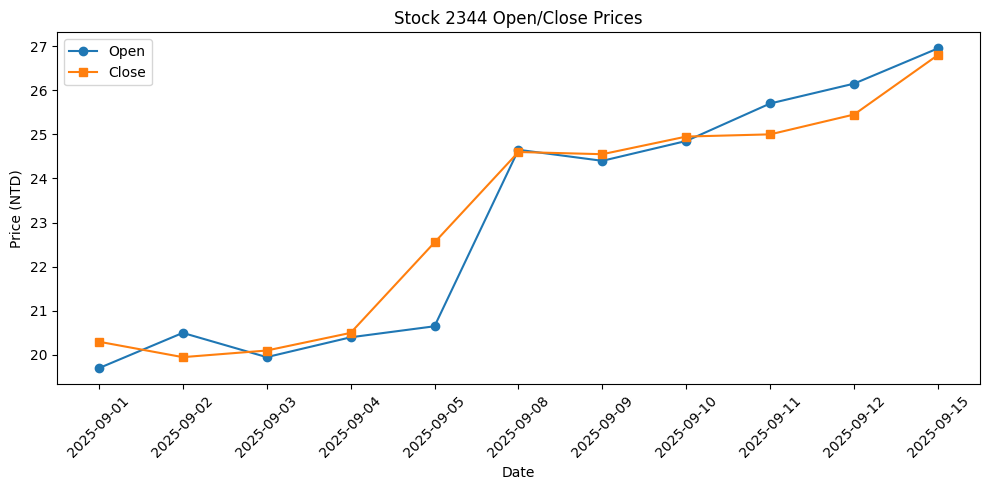

In [20]:
import matplotlib.pyplot as plt
import matplotlib
import requests
import pandas as pd
import datetime as dt
from datetime import datetime
import urllib3


# 關閉 TWSE 憑證警告
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# 股票代號
stock_id = '2344'
# 今天日期
date = dt.date.today().strftime("%Y%m%d")


print('今日日期：', date)
url = f"https://www.twse.com.tw/rwd/zh/afterTrading/STOCK_DAY?date={date}&stockNo={stock_id}"

# 抓取資料
stock_data = requests.get(url, verify=False)
json_data = stock_data.json()

# 轉 DataFrame
df = pd.DataFrame(data=json_data['data'],
                  columns=json_data['fields'])

# 民國年轉西元
df["日期"] = df["日期"].apply(
    lambda x: datetime(int(x.split("/")[0]) + 1911,
                       int(x.split("/")[1]),
                       int(x.split("/")[2])).strftime("%Y-%m-%d")
)

print(df)

# 數值轉換
df["Open"] = pd.to_numeric(df["開盤價"].str.replace(",", ""), errors="coerce")
df["Close"] = pd.to_numeric(df["收盤價"].str.replace(",", ""), errors="coerce")

#print(df[["Date", "Open", "Close"]])

# 畫圖
plt.figure(figsize=(10, 5))
plt.plot(df["日期"], df["Open"], marker="o", label="Open")
plt.plot(df["日期"], df["Close"], marker="s", label="Close")

plt.title(f"Stock {stock_id} Open/Close Prices")
plt.xlabel("Date")
plt.ylabel("Price (NTD)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## 用 BeautifulSoup4 取得 Yahoo 股市資料

### ⚠️ 如果過度頻繁爬取證交所的資料(約連續50次)會被偵測並封鎖IP，可以搭配time、sleep延遲回應避免被認為是機器人程式。

###匯入套件

In [21]:
# 用來處理時間
from datetime import datetime, timedelta
# 解析網頁內容
from bs4 import BeautifulSoup

### 取得股價資料

In [22]:
def yahoo_stock(stock_id):
    # 取得證交所網站資，帶入網址參數 date：時間，stock_id：股票代號
    url = f'https://tw.stock.yahoo.com/quote/{stock_id}.TW'

    # 使用 requests 取得網頁內容
    response = requests.get(url)

    # 取得 HTML 文本
    html = response.content

    # 使用 Beautiful Soup 解析 HTML 內容
    soup = BeautifulSoup(html, 'html.parser')

    # 使用 find 與 find_all 定位 HTML 的標籤
    # HTML 標籤中的 section id=qsp-overview-realtime-info 下的 time
    time_element = soup.find('section',\
                {'id': 'qsp-overview-realtime-info'}).find('time')
    # HTML 標籤中的 section id=qsp-overview-realtime-info 下的 ul li
    table_soups = soup.find('section',\
                {'id': 'qsp-overview-realtime-info'}).find('ul')\
                                   .find_all('li')

    # 欄位資料
    fields = []
    # 放資料
    datas = []

    # 使用 for 迴圈取得表格中細部內容
    for table_soup in table_soups:

        # 表格中的 span 標籤
        table_datas = table_soup.find_all('span')

        for num, table_data in enumerate(table_datas):

            if table_data.text == '': # 表格內容空就跳過
                continue

            # 新增資料
            if num == 0:
                fields.append(table_data.text)
            else:
                datas.append(table_data.text)

    # 建立 DataFrame
    df = pd.DataFrame([datas], columns=fields)

    # 增加日期和股號欄位
    df.insert(0,'日期',time_element['datatime'])
    df.insert(1,'股號',stock_id)

    # 回傳 DataFrame
    return df


'''main'''

# "華邦電"股票代號
stock_id = '2344'

# 呼叫定義函數
yahoo_stock(stock_id)

,日期,股號,成交,開盤,最高,最低,均價,成交金額(億),昨收,漲跌幅,漲跌,總量,昨量,振幅
0,2025/09/15 14:30,2344,26.80,26.95,27.10,25.70,26.65,124.57,25.45,5.30%,1.35,"467,449","274,900",5.50%


###取得季報表資訊


In [23]:
url = f'https://tw.stock.yahoo.com/quote/{stock_id}/income-statement'
words = url.split('/')
print(words)

k = words[-1]
print(k)

['https:', '', 'tw.stock.yahoo.com', 'quote', '2344', 'income-statement']
income-statement


In [24]:
# 函數可用於奇摩財報
def url_find(url):

    # 取得 url 的所有 route
    words = url.split('/')

    # 取得最後一個 route
    # 為了知道是損益表、資產負債表、現金流量表
    laset_word = words[-1]

    # 使用requests取得網頁內容
    response = requests.get(url)

    # 取得 HTML 文本
    html = response.content

    # 使用Beautiful Soup解析HTML內容
    soup = BeautifulSoup(html, 'html.parser')

    # 找到表格的表頭 qsp-incom-statment-table
    table_soup = soup.find('section', {'id': 'qsp-{}-table'.format(laset_word)})

    # 找到對應類別標籤
    table_fields=table_soup.find('div', class_='table-header')

    # 解析表頭內容
    table_fields_lines = list(table_fields.stripped_strings)


    # 找到對應的資料
    data_rows = table_soup.find_all('li' ,class_='List(n)')

    # 解析資料行內容
    data = []
    for row in data_rows:
        row_data = list(row.stripped_strings)
        data.append(row_data)

    # 建立 DataFrame
    df = pd.DataFrame(data, columns=table_fields_lines)
    return df

'''main'''

# 抓損益表
# url = f'https://tw.stock.yahoo.com/quote/{stock_id}/income-statement'
# 抓資產負債表
# url = f'https://tw.stock.yahoo.com/quote/{stock_id}/balance-sheet'
# 抓現金流量表
url = f'https://tw.stock.yahoo.com/quote/{stock_id}/cash-flow-statement'

# 抓取季報表資料
df = url_find(url).transpose()

# 資料處理
df.columns = df.iloc[0]
df = df[1:]
df.insert(0, '年度/季別', df.index)
df.columns.name = None
df.reset_index(drop=True, inplace=True)

# 輸出資料後5筆
print(df)

      年度/季別       營業現金流        投資現金流       融資現金流        自由現金流        淨現金流
0   2025 Q2   2,437,395   -1,824,099   2,442,633      613,296   1,938,708
1   2025 Q1     392,681   -2,045,206   5,456,635   -1,652,525   4,278,093
2   2024 Q4   2,550,284   -3,369,963    -565,004     -819,679  -1,404,264
3   2024 Q3   2,095,938   -2,982,273   2,696,394     -886,335   2,096,142
4   2024 Q2   4,756,945   -2,040,067  -2,849,374    2,716,878    -301,651
5   2024 Q1   1,722,713   -8,265,517   3,244,900   -6,542,804  -3,252,429
6   2023 Q4   2,959,830   -6,535,846     355,698   -3,576,016  -3,390,353
7   2023 Q3     548,657   -1,804,493   3,814,596   -1,255,836   2,712,497
8   2023 Q2    -395,767   -2,129,805   2,225,675   -2,525,572    -488,682
9   2023 Q1     488,753   -2,561,407     -45,642   -2,072,654  -2,273,800
10  2022 Q4   1,685,964   -6,788,663   7,336,367   -5,102,699   2,112,278
11  2022 Q3   2,212,829  -12,405,373   1,657,674  -10,192,544  -8,128,603
12  2022 Q2   3,659,648  -15,955,737  